# DreamFlow

## Intro
* **Date**: 12/3/2020
* **What**: Potentially nirvana.  Basically, it's more or less DreamComp, but I re-conceptualized it.  Basically, there are two flows of information.  The forward flow of information tries to identify which structures are present based on the presence of various constituents.  The backward flow attempt to predict the presence of prototype constituents based on which prototypes are present.  The presence of competition is absolutely essential, because it chooses from an array of existing prototypes the prototype that best corresponds to the incoming data.  It essentially chooses which structures are currently present based on the state of the data.  
* **Why**: Because I think this might be nirvana.  I mean, unless something really unpredictable happens.  This algorithm would be way more efficient on an FPGA because it's better to think of each neuron as its own entity, rather than a row in a matrix.  So yeah, that's encouraging.
* **Hopes**: I want this algorithm to produce very good classifications.  More importantly, without trying to be over-dramatic, I want this algorithm to actually demonstrate the building blocks of intelligence. 
* **Limitations**: Only that everything constantly breaks and fails.  I really have no idea what might fail here, but it would be beyond stupid to discount that as a possibility.  

## Technicals

There are two weight matrices between neurons with even and odd parity.  

Ehh, I don't really want to write all the LateX for this.  Basically, you multiply the weight matrix by the even neurons, 
and that's your base output.  You do local competition to eliminate some of the odd neuron values, and you apply an activation
function to keep the input between 0 and 1.  You then multiply the transpose of the matrix by the resulting odd output.  This is the odd's prediction of the even values.  You then adjust the weight matrix so that the prediction is more in line with actual values.

It's that simple.

## Code

In [40]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import bsr_matrix, csr_matrix
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from time import sleep, time

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x / 255.0, test_x / 255.0

L = 28 * 28

flat_x = train_x.reshape(-1, L)
flat_test = test_x.reshape(-1, L)

In [15]:
def draw_weights(w, Kx, Ky, fig):
    tapestry = np.zeros((28 * Kx, 28 * Ky))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * 28: (y + 1) * 28, x * 28: (x + 1) * 28] = w[w_i].reshape(28, 28)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Reds", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [3]:
"""
Note: Each row of neurons is a competition cluster

Kx: num cols of neurons
Ky: num rows of neurons
flat_x: training data
train_y: training labels
Nep: num epochs
xi: training constant
fig: plt figure for drawing weights
draw: Boolean indicates whether we should draw

Returns: Synaptic weight matrix w
"""
def dream_flow(Kx, Ky, flat_x, train_y, Nep, xi, fig, draw):
    N = Kx * Ky

    train_len, L = flat_x.shape
    num_classes = np.max(train_y) + 1
    
    # Append classification information to data
    clsfn_mask = np.zeros((train_len, num_classes))
    clsfn_mask[np.arange(train_len), train_y] = 1
    
    all_e_op = np.concatenate((clsfn_mask, flat_x), axis=1)
    
    # Initialize competition clusters.  Each row is a competition cluster
    c_iT = np.zeros((Ky, Kx * Ky))

    for i in range(Ky):
        c_iT[i : i+1, i * Kx: (i + 1) * Kx] = 1

    c_i = c_iT.T
    
    # Initialize synaptic weight matrix
    w = np.random.uniform(0, 1, (N, L + num_classes))
    
    for ep in range(Nep):
        a_e_op = all_e_op[np.random.permutation(train_len)]
        
        for i in tqdm(range(train_len)):
            e_op = a_e_op[i].reshape(-1, 1)
            
            o_i = w @ e_op
            o_wins = np.argmax(c_i * o_i, axis=0)
            
            o_mask = np.zeros((N, 1))
            o_mask[o_wins] = 1
            
            o_op = np.tanh(o_i * o_mask)
            
            e_pred = w.T @ o_op
            base_dw = w * o_op
            
            w += ((xi * (e_op - e_pred) / e_pred).T * base_dw)
            
        if draw:
            draw_weights(w[:, num_classes:], Ky, Kx, fig)
        
    return w, c_i

In [4]:
def df_classifier(w, flat_test, test_y, c_i):
    num_classes = np.max(test_y) + 1
    test_len = flat_test.shape[0]
    
    zero_mask = np.zeros((test_len, num_classes))
    all_e_op = np.concatenate((zero_mask, flat_test), axis=1)
    
    N = w.shape[0]
    
    print("Starting classification")
    
    num_correct = 0
    for (e_opT, lbl) in tqdm(zip(all_e_op, test_y)):
        e_op = e_opT.reshape(-1, 1)
        
        o_i = w @ e_op
        o_wins = np.argmax(c_i * o_i, axis=0)

        o_mask = np.zeros((N, 1))
        o_mask[o_wins] = 1

        o_op = np.tanh(o_i * o_mask)

        e_pred = w.T @ o_op
        
        class_pred = np.argmax(e_pred[:num_classes])
        
        if class_pred == lbl:
            num_correct += 1
        
    accuracy = num_correct / test_len
    print("Accuracy: ", str(100 * accuracy) + '%')
    
    return accuracy

In [5]:
def plot_class_weights(w, num_classes, x, y):
    fig = plt.figure(figsize=(2 * x, 2 * y))
    
    w_cls = w[:, :num_classes]
    
    for (i, cls_weights) in enumerate(w_cls[: x * y]):
        plt.subplot(y, x, i + 1)
        plt.yticks([])
        plt.xticks(np.arange(num_classes))
        plt.bar(np.arange(num_classes), cls_weights)
        
    plt.show()

100%|█████████████████████████████████████████████████████████| 60000/60000 [00:27<00:00, 2181.77it/s]


Starting classification


10000it [00:02, 4005.88it/s]


Accuracy:  62.43%


0.6243

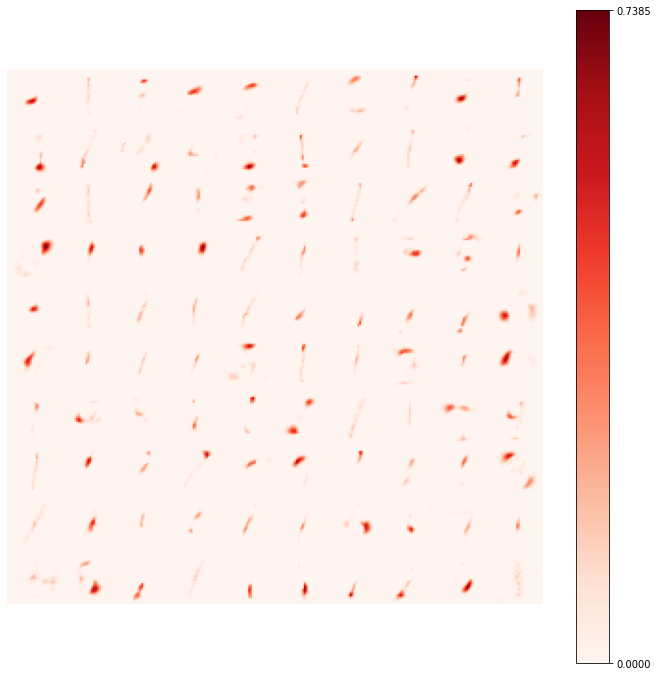

In [65]:
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 10
Ky = 10
Nep = 4
xi = 0.01
draw = True
T_s = 60000

w, c_i = dream_flow(Kx, Ky, flat_x[:T_s], train_y[:T_s], Nep, xi, fig, draw)
df_classifier(w, flat_test, test_y, c_i)

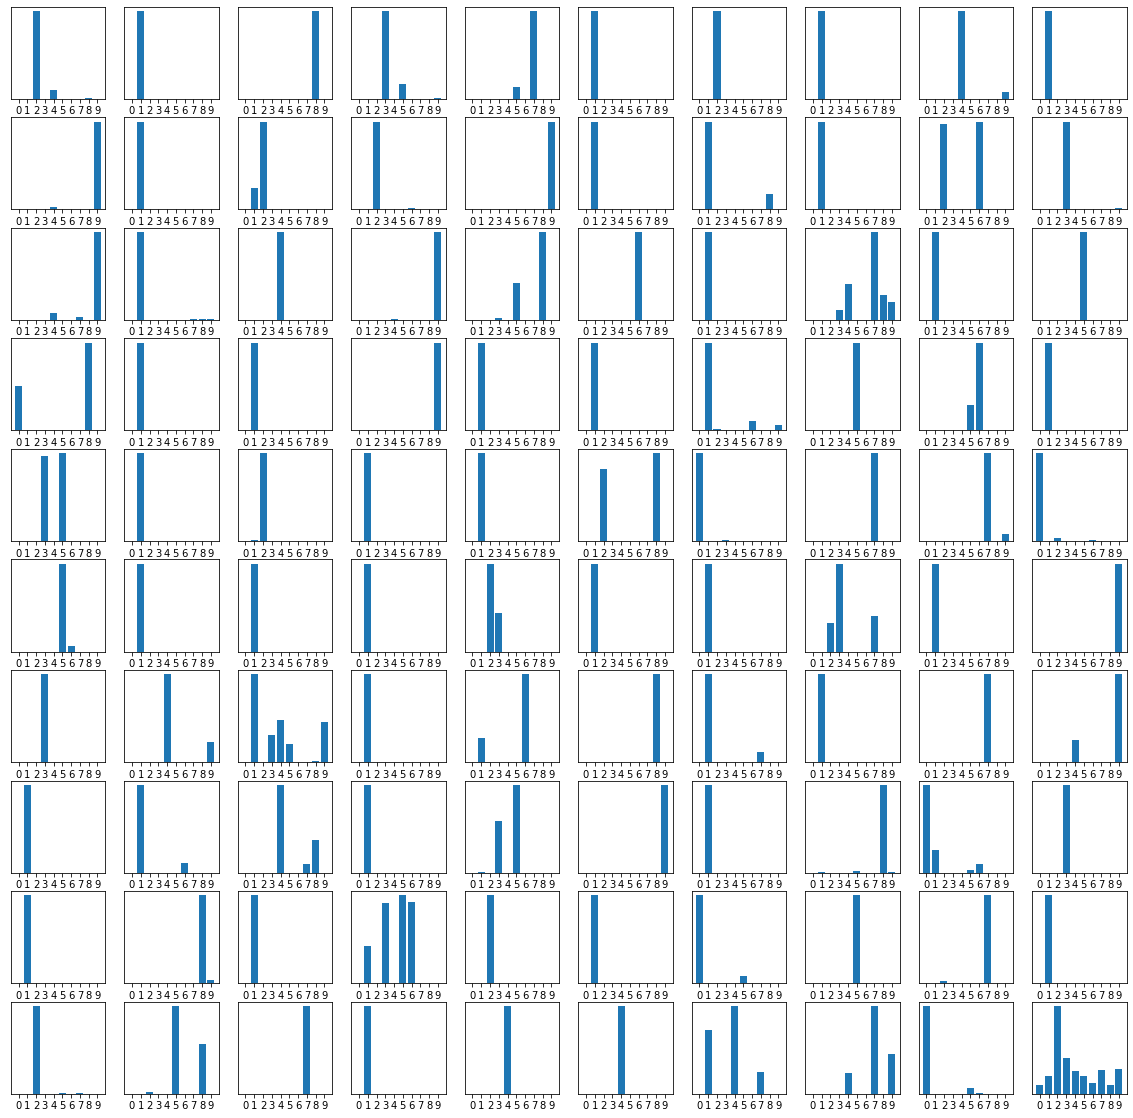

In [66]:
plot_class_weights(w, 10, 10, 10)

## Analysis Dialog

Ok.  Well, this is interesting.  While the network doesn't do horribly, there certainly is still some confusion about which classifications particular pieces correspond to.  And that certainly makes sense, especially if there are certain parts of numbers that correspond to multiple types of structures.  

So, basically, we need multiple layers.  

I was thinking that I would need two matrices, but I actually think one will suffice.  And one big square matrix that represents the synapses.  And, you now what?  I think I could actually mini-batch this network if it's just doing classification tasks.  

Yeah. I just need a big honker of a square matrix.  

12/4/20: Ok, a day has gone by.  I don't believe that simply trying to classify the digits by a set of constituent structures is really the way to go.  So I want to try a couple things.  

First, and most in line with what I've been doing, I'm going to try a 2-layer network, where the second layer is memorizing the configurations of the first layer, which is learning important parts of digits, like what we saw in the last cell.  

Before I do that, I'm going to run a 25 neuron network, and a 400 neuron network with the above architectures.

100%|█████████████████████████████████████████████████████████| 60000/60000 [00:16<00:00, 3630.90it/s]


Starting classification


10000it [00:01, 5079.40it/s]


Accuracy:  58.489999999999995%


0.5849

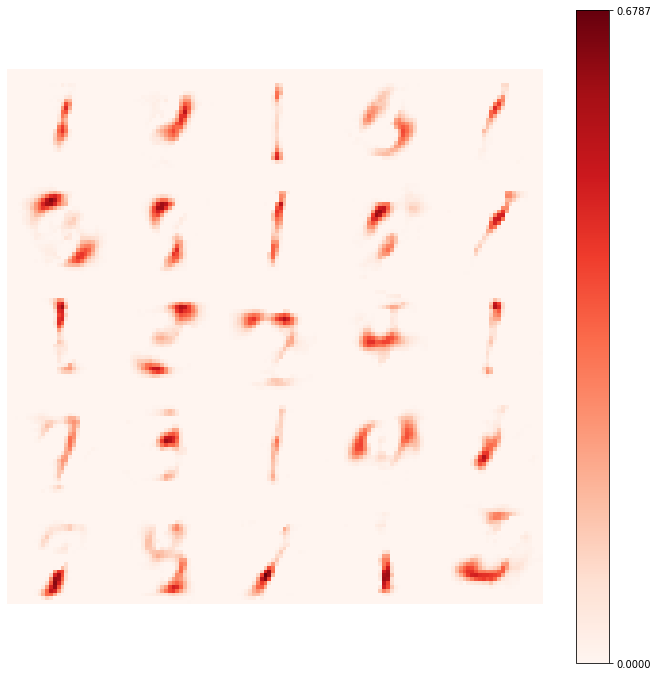

In [6]:
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx = 5
Ky = 5
Nep = 4
xi = 0.01
draw = True
T_s = 60000

w, c_i = dream_flow(Kx, Ky, flat_x[:T_s], train_y[:T_s], Nep, xi, fig, draw)
df_classifier(w, flat_test, test_y, c_i)

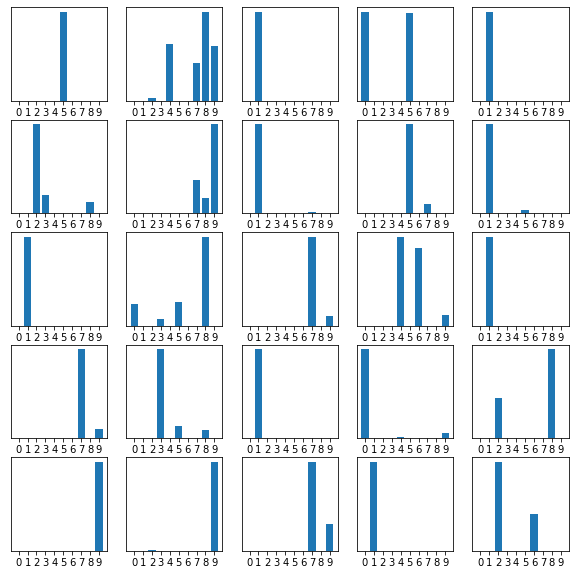

In [7]:
plot_class_weights(w, 10, 5, 5)

Actually, belay what I said about 400 neurons.  That will simply take far too long.  I absolutely need to batch this algo.  It's insufferable without it.  Or I need to run it on GPU.  

Ok, anyway, let's try the 2-layer architecture.  Or, I guess it's 4 layers, if you include the input and classification layers. 

I think just overall, I need to get a better understanding of what occurs in forward flow, and what occurs in backward flow.  

Ok, here's the batched 4-layer DreamFlow algo.

In [8]:
"""
Kx1: num cols of first layer
Ky1: num rows of first layer
Kx2: num cols of second layer
Ky2: num rows of second layer

flat_x: training data
train_y: training labels

Nep: Number of Epochs
B: Batch size

prec: Precision of update

xi: Learning constant

draw: Whether it should draw the weights
"""
def dream_flow_mb(Kx1, Ky1, Kx2, Ky2, flat_x, train_y, Nep, B, prec, xi, fig, draw):
    N1 = Kx1 * Ky1
    N2 = Kx2 * Ky2
    
    train_len, input_len = flat_x.shape
    num_classes = np.max(train_y) + 1
    
    ext_in_len = input_len + num_classes
    
    # Initialize input data
    clsfn_mask = np.zeros((train_len, num_classes))
    clsfn_mask[np.arange(train_len), train_y] = 1
    
    flat_in = np.concatenate((clsfn_mask, flat_x, np.zeros((train_len, N1)), np.zeros((train_len, N2))), axis=1)
    
    in_len = flat_in.shape[1]
    
    # Initialize competition clusters
    c_i = np.zeros((Ky1 + 1, in_len))
    
    for i in range(Ky1):
        c_i[i, ext_in_len + (i * Kx1): ext_in_len + ((i + 1) * Kx1)] = 1
        
    c_i[Ky1, ext_in_len + N1:] = 1
    
    num_clusters = c_i.shape[0]
    
    # Initialize synapse weights
    w = np.zeros((in_len, in_len))
    
    print(num_classes, ext_in_len, N1, N2)
    
    w[:num_classes, ext_in_len:] = np.random.uniform(0, 1, (num_classes, N1 + N2))
    w[num_classes: ext_in_len, ext_in_len: -N2] = np.random.uniform(0, 1, (input_len, N1))
    w[ext_in_len: -N2, -N2:] = np.random.uniform(0, 1, (N1, N2))
    
    for ep in range(Nep):
        inputs = flat_in[np.random.permutation(train_len)]
        
        for i in tqdm(range(train_len//B)):
            v0 = inputs[i * B: (i + 1) * B]
            
            v0_w = v0 @ w
            
            c_clusters = v0_w * c_i.reshape(num_clusters, 1, in_len)
            c_win_i = np.argmax(c_clusters, axis=2).T.reshape(1, -1)
            c_mask = np.zeros((B, in_len))
            c_mask[np.repeat(np.arange(B), num_clusters), c_win_i] = 1
            
            v1 = c_mask * v0_w
            
            v1_w = (v0 + v1) @ w
            
            c_clusters = v1_w * c_i.reshape(num_clusters, 1, in_len)
            c_win_i = np.argmax(c_clusters, axis=2).T.reshape(1, -1)
            c_mask = np.zeros((B, in_len))
            c_mask[np.repeat(np.arange(B), num_clusters), c_win_i] = 1
            
            v2 = c_mask * v1_w
            
            pred = v2 @ w.T
            
            base_dw = v2.reshape(B, 1, -1) * w
            big_dw = (v2 - pred).reshape(B, -1, 1) * base_dw
            
            dw = np.sum(big_dw, axis=0)
            
            max_d = np.max(dw)
            
            if max_d < prec:
                max_d = prec
                
#             print(max_d)
            
            w += (xi / max_d) * dw
            
        draw_weights(w[num_classes: ext_in_len, ext_in_len:-N2].T, Kx1, Ky1, fig)
        
    return w

10 794 100 100


100%|███████████████████████████████████████████████████████████████| 600/600 [09:49<00:00,  1.04it/s]


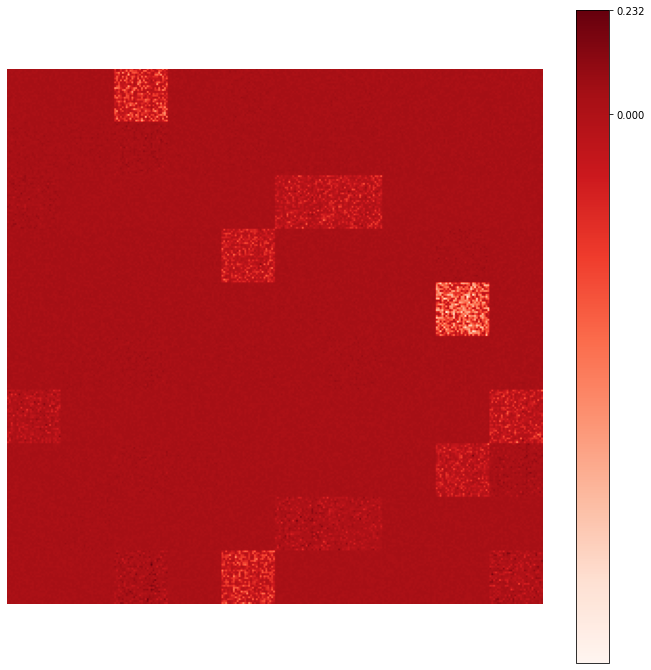

In [10]:
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx1 = 10
Ky1 = 10

Kx2 = 10 
Ky2 = 10

Nep = 1
B = 100

T_s = 60000

prec = 1e-30

xi = 0.001
draw = True

w = dream_flow_mb(Kx1, Ky1, Kx2, Ky2, flat_x[:T_s], train_y[:T_s], Nep, B, prec, xi, fig, draw)

Well, I really, really hate that.  Not only did that take a bajillion years to run, but I mean look at those prototypes.  I guess I maybe should have used x=0.01, but still, something's fishy here.  I don't feel like those prototypes should be that poor.  Also that algo took *waaaaaay* too long.  I'm going to see if I can speed things up with sparse matrices, but if I can't, then we're going to have to try something other than one stupid huge matrix.  

Alright.  I'm going to try using bsr_matrices. Edit: I'm going to try csr_matrices

In [55]:
"""
Kx1: num cols of first layer
Ky1: num rows of first layer
Kx2: num cols of second layer
Ky2: num rows of second layer

flat_x: training data
train_y: training labels

Nep: Number of Epochs
B: Batch size

prec: Precision of update

xi: Learning constant

draw: Whether it should draw the weights
"""
def dream_flow_mb_csr(Kx1, Ky1, Kx2, Ky2, flat_x, train_y, Nep, B, prec, xi, fig, draw):
    N1 = Kx1 * Ky1
    N2 = Kx2 * Ky2
    
    train_len, input_len = flat_x.shape
    num_classes = np.max(train_y) + 1
    
    ext_in_len = input_len + num_classes
    
    # Initialize input data
    clsfn_mask = np.zeros((train_len, num_classes))
    clsfn_mask[np.arange(train_len), train_y] = 1
    
    flat_in = np.concatenate((clsfn_mask, flat_x, np.zeros((train_len, N1)), np.zeros((train_len, N2))), axis=1)
    
    in_len = flat_in.shape[1]
    
    # Initialize competition clusters
    c_i = np.zeros((Ky1 + 1, in_len))
    
    for i in range(Ky1):
        c_i[i, ext_in_len + (i * Kx1): ext_in_len + ((i + 1) * Kx1)] = 1
        
    c_i[Ky1, ext_in_len + N1:] = 1
    
    num_clusters = c_i.shape[0]

    c_i = c_i.reshape(num_clusters, 1, in_len)
        
    # Initialize synapse weights
    w = np.zeros((in_len, in_len))
    
    print(num_classes, ext_in_len, N1, N2)
    
    w[:num_classes, ext_in_len:] = np.random.uniform(0, 1, (num_classes, N1 + N2))
    w[num_classes: ext_in_len, ext_in_len: -N2] = np.random.uniform(0, 1, (input_len, N1))
    w[ext_in_len: -N2, -N2:] = np.random.uniform(0, 1, (N1, N2))
    
    w = csr_matrix(w)
    
    for ep in range(Nep):
        inputs = flat_in[np.random.permutation(train_len)]
        
        for i in tqdm(range(train_len//B)):
            v0 = inputs[i * B: (i + 1) * B]
            
            v0_w = v0 @ w
            
            c_clusters = v0_w * c_i
            c_win_i = np.argmax(c_clusters, axis=2).T.reshape(1, -1)
            c_mask = np.zeros((B, in_len))
            c_mask[np.repeat(np.arange(B), num_clusters), c_win_i] = 1
            
            v1 = c_mask * v0_w
            
            v1_w = (v0 + v1) @ w
            
            c_clusters = v1_w * c_i
            c_win_i = np.argmax(c_clusters, axis=2).T.reshape(1, -1)
            c_mask = np.zeros((B, in_len))
            c_mask[np.repeat(np.arange(B), num_clusters), c_win_i] = 1
            
            v2 = c_mask * v1_w
            
            pred = v2 @ w.T
            
            base_dw = w.multiply(v2.reshape(B, 1, -1)) 
            big_dw = base_dw * (v2 - pred).reshape(B, -1, 1) 
            
            dw = np.sum(big_dw, axis=0)
            
            print(dw)
            
            max_d = np.max(dw)
            
            if max_d < prec:
                max_d = prec
                
#             print(max_d)
            
            w += (xi / max_d) * dw
            
        draw_weights(w[num_classes: ext_in_len, ext_in_len:-N2].T, Kx1, Ky1, fig)
        
    return w

In [56]:
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))

Kx1 = 10
Ky1 = 10

Kx2 = 10 
Ky2 = 10

Nep = 1
B = 100

T_s = 60000

prec = 1e-30

xi = 0.001
draw = True

w = dream_flow_mb_csr(Kx1, Ky1, Kx2, Ky2, flat_x[:T_s], train_y[:T_s], Nep, B, prec, xi, fig, draw)

10 794 100 100


  0%|                                                                         | 0/600 [00:00<?, ?it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  0%|                                                                 | 1/600 [00:00<09:16,  1.08it/s]


ValueError: shapes (100,994) and (11,994) not aligned: 994 (dim 1) != 11 (dim 0)

<Figure size 864x864 with 0 Axes>

You know what?? Fuck this.  Fuck it.  I'm just going to implement multilayer DreamFlow in terms of several different matrices.  God help me.  But first, I'm going to go take a walk.

In [19]:
from scipy.sparse import bsr_matrix

In [10]:
N1 = 20
N2 = 40

train_len, input_len = flat_x.shape
num_classes = np.max(train_y) + 1

clsfn_mask = np.zeros((train_len, num_classes))
clsfn_mask[np.arange(train_len), train_y] = 1

flat_in = np.concatenate((clsfn_mask, flat_x, np.zeros((train_len, N1)), np.zeros((train_len, N2))), axis=1)

In [12]:
flat_in.shape

(60000, 854)

In [22]:
a = np.array([[1, 2], [4,5]])

In [24]:
b = bsr_matrix(a)

In [37]:
b.T.toarray()

array([[1, 4],
       [2, 5]], dtype=int32)

In [28]:
bsr_matrix(w, blocksize=(14, 71))

<994x994 sparse matrix of type '<class 'numpy.float64'>'
	with 129220 stored elements (blocksize = 14x71) in Block Sparse Row format>

In [19]:
c = np.random.uniform(0, 1, (3, 3))

In [20]:
c

array([[0.37020054, 0.98535742, 0.576022  ],
       [0.71486298, 0.95461705, 0.09235079],
       [0.3714951 , 0.78163928, 0.80592493]])

In [21]:
c[:2, 1:] = np.array([[2, 3], [4, 3]])

In [22]:
c

array([[0.37020054, 2.        , 3.        ],
       [0.71486298, 4.        , 3.        ],
       [0.3714951 , 0.78163928, 0.80592493]])

In [18]:
a[1, 0:1]

array([4])

In [24]:
a = np.array([[1,2], [4, 6]])

In [25]:
b = a * np.array([[[1, 2]], [[45, 2.3]], [[3, 4]]])
b

array([[[  1. ,   4. ],
        [  4. ,  12. ]],

       [[ 45. ,   4.6],
        [180. ,  13.8]],

       [[  3. ,   8. ],
        [ 12. ,  24. ]]])

In [26]:
np.max(b, axis=2).T.reshape(1, -1)


array([[  4.,  45.,   8.,  12., 180.,  24.]])

In [27]:
a[[0, 1], [1, 0]] = 2

In [28]:
b

array([[[  1. ,   4. ],
        [  4. ,  12. ]],

       [[ 45. ,   4.6],
        [180. ,  13.8]],

       [[  3. ,   8. ],
        [ 12. ,  24. ]]])

In [29]:
np.sum(b, axis=0)

array([[ 49. ,  16.6],
       [196. ,  49.8]])

In [106]:
np.repeat(np.arange(1, 5), 4)

array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4])